In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from virtual_rodent.environment import MAPPER
from virtual_rodent import VISION_DIM, PROPRI_DIM, ACTION_DIM
from virtual_rodent.network.vision_enc import ResNet18Enc
from virtual_rodent.network.propri_enc import MLPEnc
import virtual_rodent.network.Merel2019 as Merel2019
from virtual_rodent.utils import load_checkpoint

In [3]:
propri_emb_dim = 20
vision_emb_dim = 20
vision_enc = ResNet18Enc(vision_emb_dim)
propri_enc = MLPEnc(PROPRI_DIM[0], propri_emb_dim, hidden_dims=(50,))

critic_in_dim = vision_emb_dim + propri_emb_dim
critic = Merel2019.Critic(critic_in_dim)

actor_in_dim = critic_in_dim + PROPRI_DIM[0] + critic.hidden_dim
actor = Merel2019.Actor(actor_in_dim, ACTION_DIM, logit_scale=1)

model = Merel2019.MerelModel(vision_enc, propri_enc, VISION_DIM, PROPRI_DIM, 
                             actor, critic, ACTION_DIM) 

In [85]:
state_dict = torch.load('./weights3000.pth', weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [86]:
env_name = 'gaps'
# env_name = 'maze'
env, propri_attr = MAPPER[env_name](physics_dt=0.002, ctrl_dt=0.02)

In [87]:
import time
from virtual_rodent.simulation import get_vision, get_propri
def simulate(env, model, propri_attr, max_step, device, reset=True, time_step=None,
             ext_cam=(0,), ext_cam_size=(200, 200), train=False):
    ''' Simulate until stop criteron is met
    '''
    start_time = time.time()

    returns = dict(vision=[], propri=[], action=[], reward=[], log_prob=[], value=[], time_step=[])
    returns.update(dict({f'cam{i}': [] for i in ext_cam}))
    
    if reset:
        time_step = env.reset()
        if hasattr(model, 'reset_rnn'):
            model.reset_rnn()
    else:
        if time_step is None:
            raise ValueError('`time_step` must be given if not reset.')

    action_spec = env.action_spec()

    for step in range(max_step):
        if time_step.last():
            break
        # Get state, reward and discount
        vision = torch.from_numpy(get_vision(time_step)).to(device)
        propri = torch.from_numpy(get_propri(time_step, propri_attr)).to(device)

        value, (action_raw, action, log_prob, _) = model(vision=vision, propri=propri, train=train)

        time_step = env.step(np.clip(action.detach().cpu().squeeze().numpy(), 
                                     action_spec.minimum, action_spec.maximum))
        # time_step = env.step(np.clip(np.random.normal(0, 0.5, size=38), 
        #                              action_spec.minimum, action_spec.maximum))

        # Record state t, action t, reward t and done t+1; reward at start is 0
        returns['vision'].append(vision)
        returns['propri'].append(propri)
        # returns['action'].append(action_raw)
        returns['time_step'].append(time_step)
        returns['reward'].append(torch.tensor(time_step.reward))
        # returns['log_prob'].append(log_prob)
        # returns['value'].append(value)
        for i in ext_cam:
            cam = env.physics.render(camera_id=i, 
                    height=ext_cam_size[0], width=ext_cam_size[1])
            returns[f'cam{i}'].append(cam)

    end_time = time.time()
    returns['time'] = end_time - start_time
    returns['T'] = step 
    return returns

In [88]:
from virtual_rodent.visualization import video
# from virtual_rodent.simulation import simulate
ext_cam = (2,)
save_dir = './'
ext_cam_size = (200, 200)
with torch.no_grad():
    ret = simulate(env, model, propri_attr, max_step=150, device=torch.device('cpu'), 
                   ext_cam=ext_cam, train=True)
for i in ext_cam:
    anim = video(ret[f'cam{i}'])
    fname = f'demo_{env_name}_cam{i}.gif'
    anim.save(os.path.join(save_dir, fname), writer='pillow')

In [89]:
%matplotlib inline

In [90]:
ret['time_step'][0].observation.keys()

odict_keys(['walker/actuator_activation', 'walker/appendages_pos', 'walker/body_height', 'walker/egocentric_camera', 'walker/end_effectors_pos', 'walker/joints_pos', 'walker/joints_vel', 'walker/sensors_accelerometer', 'walker/sensors_force', 'walker/sensors_gyro', 'walker/sensors_torque', 'walker/sensors_touch', 'walker/sensors_velocimeter', 'walker/tendons_pos', 'walker/tendons_vel', 'walker/world_zaxis'])

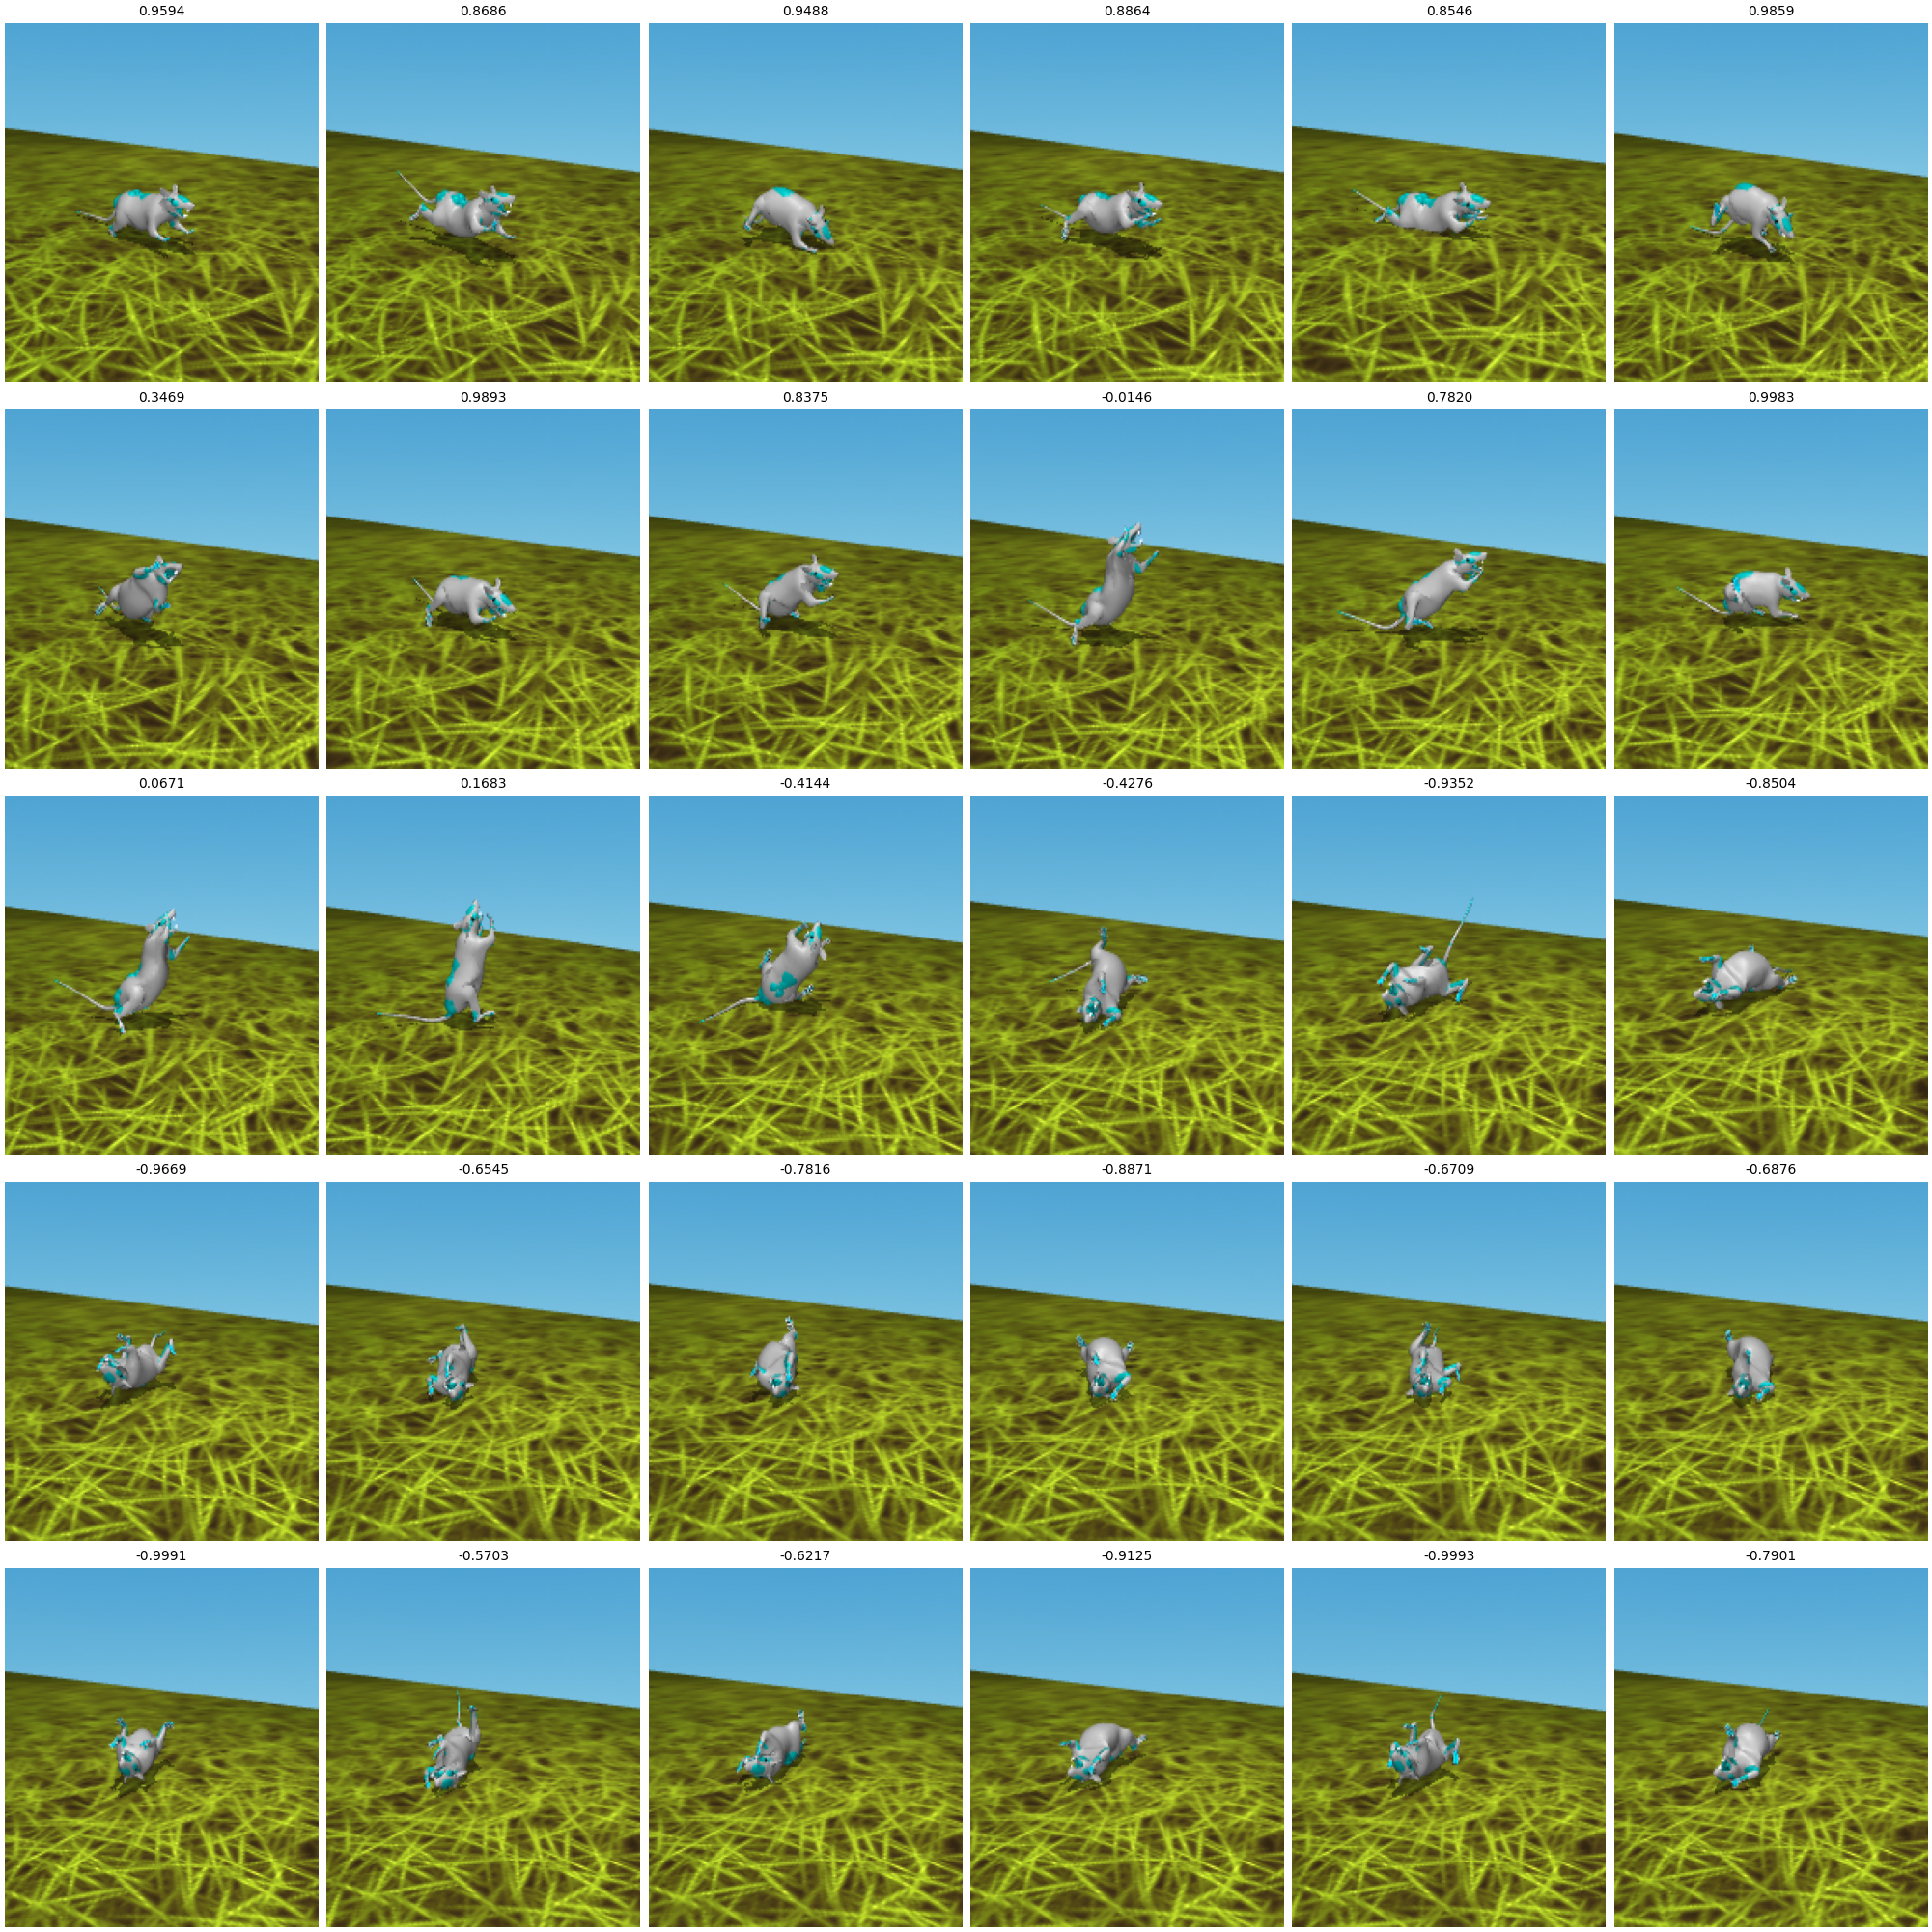

In [91]:
fig, ax = plt.subplots(5, 6, figsize=(20, 20))
for i in range(30):
    ax[i//6,i%6].set_axis_off()
    ax[i//6,i%6].imshow(ret['cam2'][i*150//30])
    y = ret['time_step'][i*150//30].observation['walker/world_zaxis'][2]
    ax[i//6,i%6].set_title(f'{y:.4f}')

In [ ]:
# v = torch.stack([vision_enc(i) for i in ret['vision']])
# p = torch.stack([propri_enc(i) for i in ret['propri']])
# a = torch.concat(ret['action']).squeeze()
# fig, ax = plt.subplots(1, 3)
# ax[0].imshow(v.data)
# ax[1].imshow(p.data)
# ax[2].imshow(a.data)